In [2]:
import pandas as pd
df1 = pd.read_csv("C:/Users/harsa/Desktop/New Folder/df1_formatted_dates.csv")
df2 = pd.read_csv("C:/Users/harsa/Desktop/New Folder/COVID-19-Faelle_7-Tage-Inzidenz_Bundeslaender.csv")
df3 = pd.read_csv("C:/Users/harsa/Desktop/New Folder/Aktuell_Deutschland_COVID-19-Hospitalisierungen.csv")
# convert to pickel or parquet format

# 📊 **Project: THE VULNERABLE**
### *Who was impacted the most in the COVID-19 pandemic?*

In [3]:
# ============================================================================
# RESEARCH PROJECT: "THE VULNERABLE" - COVID-19 Age & Regional Disparities
# ============================================================================
# 4 Research Questions on German RKI Data (df1, df2, df3)
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set visualization style
plt.style.use('default')
sns.set_palette("husl")

print("=" * 80)
print("RESEARCH PROJECT: THE VULNERABLE")
print("Analyzing who paid the highest price in the COVID-19 pandemic")
print("=" * 80)

RESEARCH PROJECT: THE VULNERABLE
Analyzing who paid the highest price in the COVID-19 pandemic


## **Data Preparation**

In [4]:
import pandas as pd
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ------------------------------------------------------------------------------
# 1. CONFIGURATION
# ------------------------------------------------------------------------------
# Define raw file paths (Update these paths to match your system)
RAW_FILES = {
    "deaths": r"df1_formatted_dates.csv",
    "cases": r"COVID-19-Faelle_7-Tage-Inzidenz_Bundeslaender.csv",
    "hosp": r"Aktuell_Deutschland_COVID-19-Hospitalisierungen.csv",
    "mobility": r"Global_Mobility_Report.csv"
}

# Output directory for optimized files
OUTPUT_DIR = "processed_data" 

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# ------------------------------------------------------------------------------
# 2. OPTIMIZATION FUNCTIONS
# ------------------------------------------------------------------------------

def optimize_deaths(df):
    """Optimizes the Deaths dataset"""
    # Date conversion
    if 'Meldedatum' in df.columns:
        df['Meldedatum'] = pd.to_datetime(df['Meldedatum'])
    
    # Filter invalid rows
    if 'NeuerTodesfall' in df.columns:
        df = df[df['NeuerTodesfall'] >= 0].copy()
        
    # Downcast numeric types for memory savings
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
        
    return df

def optimize_cases(df):
    """Optimizes the Cases dataset"""
    # Date conversion
    if 'Meldedatum' in df.columns:
        df['Meldedatum'] = pd.to_datetime(df['Meldedatum'])
        
    # Select only essential columns to reduce file size
    keep_cols = ['Meldedatum','Bundesland_id','Altersgruppe','Bevoelkerung','Faelle_gesamt','Faelle_neu','Faelle_7-Tage','Inzidenz_7-Tage']
    final_cols = [c for c in keep_cols if c in df.columns]
    
    # Use category type for repetitive strings (huge memory saver)
    df = df[final_cols].copy()
    for col in ['Bundesland', 'Altersgruppe', 'Geschlecht']:
        if col in df.columns:
            df[col] = df[col].astype('category')
            
    return df

def optimize_hosp(df):
    """Optimizes the Hospitalization dataset"""
    # Date conversion
    if 'Datum' in df.columns:
        df['Datum'] = pd.to_datetime(df['Datum'])
        
    # Optimize types
    for col in df.select_dtypes(include=['object']).columns:
        if col in ['Bundesland', 'Altersgruppe']:
             df[col] = df[col].astype('category')
             
    return df

def optimize_world(df):
    """Optimizes the International dataset"""
    # Date conversion
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        
    # Smart Country Detection
    country_col = None
    for candidate in ['location', 'country', 'Entity', 'iso_code']:
        if candidate in df.columns:
            country_col = candidate
            break
            
    if country_col:
        print(f"    > Detected country column: '{country_col}'")
        targets = ['Germany', 'France', 'Austria', 'Netherlands', 'Poland', 'Belgium']
        
        # If ISO codes, use codes
        if country_col == 'iso_code':
            targets = ['DEU', 'FRA', 'AUT', 'NLD', 'POL', 'BEL']
            
        # Filter dataset
        df = df[df[country_col].isin(targets)].copy()
        
        # Convert country column to category
        df[country_col] = df[country_col].astype('category')
    else:
        print("    > ⚠️ No country column found, saving full dataset.")
        
    return df

def optimize_mobility(df):
    """Optimizes the International dataset"""
    # Date conversion
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        
    # Smart Country Detection
    country_col = None
    for candidate in ['location', 'country_region', 'Entity', 'iso_code']:
        if candidate in df.columns:
            country_col = candidate
            break
            
    if country_col:
        print(f"    > Detected country column: '{country_col}'")
        targets = ['Germany', 'France', 'Austria', 'Netherlands', 'Poland', 'Belgium']
        
        # If ISO codes, use codes
        if country_col == 'iso_code':
            targets = ['DEU', 'FRA', 'AUT', 'NLD', 'POL', 'BEL']
            
        # Filter dataset
        df = df[df[country_col].isin(targets)].copy()
        
        # Convert country column to category
        df[country_col] = df[country_col].astype('category')
    else:
        print("    > ⚠️ No country column found, saving full dataset.")
        
    return df
# Map functions
optimizers = {
    "deaths": optimize_deaths,
    "cases": optimize_cases,
    "hosp": optimize_hosp,
    "world": optimize_world,
    "mobility": optimize_mobility
}

# ------------------------------------------------------------------------------
# 3. EXECUTION LOOP
# ------------------------------------------------------------------------------
print(f"🚀 Starting Optimization Pipeline...")
print(f"📂 Output Directory: {os.path.abspath(OUTPUT_DIR)}\n")

for name, raw_path in RAW_FILES.items():
    # Define output path (Parquet is recommended, change to .pkl if preferred)
    out_path = os.path.join(OUTPUT_DIR, f"{name}_optimized.parquet")
    
    if not os.path.exists(raw_path):
        print(f"⚠️  Source file not found: {raw_path}")
        continue
        
    print(f"Processing '{name}'...")
    try:
        # 1. Read
        df = pd.read_csv(raw_path)
        orig_mem = df.memory_usage(deep=True).sum() / 1024**2
        
        # 2. Optimize
        optimizer = optimizers.get(name)
        if optimizer:
            df = optimizer(df)
            
        # 3. Save
        # Parquet is faster and smaller than CSV for this data
        df.to_parquet(out_path, index=False)
        
        new_mem = df.memory_usage(deep=True).sum() / 1024**2
        print(f"  ✓ Saved to: {out_path}")
        print(f"  📉 Memory reduced: {orig_mem:.2f} MB -> {new_mem:.2f} MB")
        
    except Exception as e:
        print(f"  ❌ Error: {e}")

print("\n✅ Pipeline Complete. Use 'pd.read_parquet()' to load these files instantly.")


🚀 Starting Optimization Pipeline...
📂 Output Directory: c:\Users\harsa\Desktop\New folder\Research questions\hooks\processed_data

Processing 'deaths'...
  ✓ Saved to: processed_data\deaths_optimized.parquet
  📉 Memory reduced: 0.65 MB -> 0.58 MB
Processing 'cases'...
  ✓ Saved to: processed_data\cases_optimized.parquet
  📉 Memory reduced: 36.34 MB -> 12.91 MB
Processing 'hosp'...
  ✓ Saved to: processed_data\hosp_optimized.parquet
  📉 Memory reduced: 46.55 MB -> 7.96 MB
Processing 'mobility'...
    > Detected country column: 'country_region'
  ✓ Saved to: processed_data\mobility_optimized.parquet
  📉 Memory reduced: 5505.82 MB -> 369.44 MB

✅ Pipeline Complete. Use 'pd.read_parquet()' to load these files instantly.


In [5]:
# ============================================================================
# STEP 1: DATA PREPARATION
# ============================================================================

print("\n[STEP 1] Preparing data...")

# Filter Germany data
de_df1_states = pd.read_parquet(r'C:\Users\harsa\Desktop\New folder\Research questions\hooks\processed_data\deaths_optimized.parquet')  # All 16 states (deaths)
de_df2_cases = pd.read_parquet(r'C:\Users\harsa\Desktop\New folder\Research questions\hooks\processed_data\cases_optimized.parquet')   # All states with age groups (cases)
de_df3_hosp = pd.read_parquet(r'C:\Users\harsa\Desktop\New folder\Research questions\hooks\processed_data\hosp_optimized.parquet')    # Hospitalizations by age/region

# Get Germany-wide totals from df3 (Bundesgebiet = Germany)
germany_hosp = de_df3_hosp[de_df3_hosp['Bundesland'] == 'Bundesgebiet'].copy()

# Get Germany-wide cases by aggregating across states
germany_cases_age = de_df2_cases.groupby(['Meldedatum', 'Altersgruppe']).agg({
    'Faelle_neu': 'sum',
    'Faelle_gesamt': 'sum',
    'Bevoelkerung': 'first'  # Population for each age group
}).reset_index()

print(f"✓ Deaths: {len(de_df1_states)} rows ({de_df1_states['Datum'].min()} to {de_df1_states['Datum'].max()})")
print(f"✓ Cases: {len(germany_cases_age)} rows")
print(f"✓ Hospitalizations: {len(germany_hosp)} rows")

total_deaths_germany = de_df1_states['Todesfaelle_gesamt'].max()




[STEP 1] Preparing data...
✓ Deaths: 4688 rows (2020-03-16 to 2025-10-20)
✓ Cases: 14847 rows
✓ Hospitalizations: 14441 rows


## **3. The Reveal (Key Visualizations)**
*   **Viz 1 (The Age Gap):** Hospitalization Incidence for 80+ vs. 35–59.
    *   *Visual:* The 80+ curve towers over all others.
*   **Viz 2 (The Decoupling):** "Severity Rate" (Hospitalizations per 100 Cases) for the elderly.
    *   *Visual:* Trend line drops in 2021 (Vaccines) and plummets in 2022 (Omicron).
*   **Viz 3 (The Regional Burden):** Bar chart ranking states by Cumulative Deaths per 100k.
    *   *Visual:* Eastern states (Saxony, Thuringia) appear at the top (worst affected).
*   **Viz 4 (The Pediatric Check):** Zoomed-in trend for ages 0–4 and 5–14.
    *   *Visual:* A visible rise during Omicron, but on a drastically smaller scale than adults.


[RQ 1] The Age Gradient: Hospitalization Risk by Age Group
--------------------------------------------------------------------------------


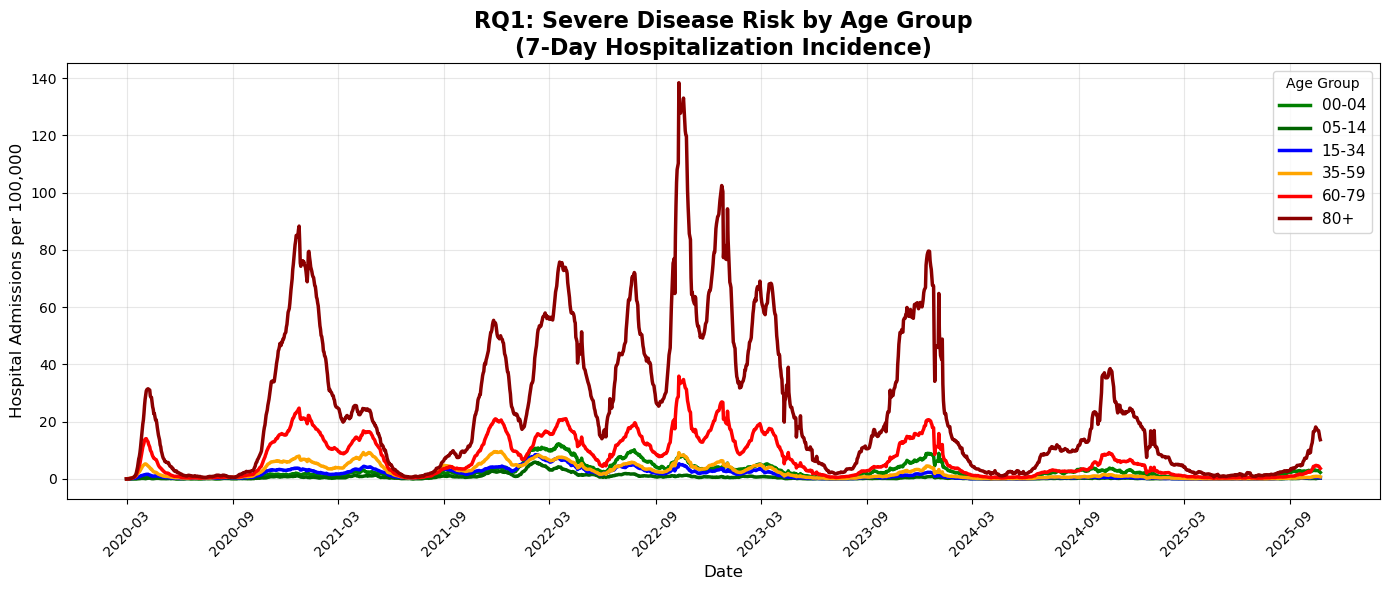


Average Hospitalization Incidence (2020–2025):
  - 35–59 age group:  2.49 per 100k
  - 80+ age group:    24.47 per 100k
  - Risk Multiplier:  9.8x


In [6]:
# ============================================================================
# STEP 2: RQ 1 - THE "AGE GRADIENT" OF SEVERITY
# ============================================================================

print("\n[RQ 1] The Age Gradient: Hospitalization Risk by Age Group")
print("-" * 80)

# Plot 1: Hospitalization Incidence Over Time by Age
fig, ax = plt.subplots(figsize=(14, 6))

age_groups = ['00-04','05-14','15-34', '35-59', '60-79', '80+']
colors = {'00-04':'green','05-14':'darkgreen','15-34': 'blue',
          '35-59': 'orange', '60-79': 'red', '80+': 'darkred'}

# Convert date column to datetime once for the entire dataset
germany_hosp_clean = germany_hosp.copy()
germany_hosp_clean['Datum'] = pd.to_datetime(germany_hosp_clean['Datum'])

# Optimized plotting loop with proper date handling
for age in age_groups:
    age_data = germany_hosp_clean[germany_hosp_clean['Altersgruppe'] == age].sort_values('Datum')
    ax.plot(age_data['Datum'], age_data['7T_Hospitalisierung_Inzidenz'],
            label=age, linewidth=2.5, color=colors[age])

# Improved date formatting
import matplotlib.dates as mdates

'''# Force datetime axis
ax.xaxis_date()
ax.axvline(x=np.datetime64('2022-01-01'), color='orange', linestyle='--',
           linewidth=2, label='Omicron Emergence')
ax.axvline(x=np.datetime64('2022-03-20'), color='red', linestyle='--',
           linewidth=2, label='Normal Daily life Started (Masks mandatory)')
ax.axvline(x=np.datetime64('2023-04-07'), color='darkred', linestyle='--',
           linewidth=2, label='Lockdown Lifted')'''
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

ax.set_title('RQ1: Severe Disease Risk by Age Group\n(7-Day Hospitalization Incidence)',
             fontsize=16, weight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Hospital Admissions per 100,000', fontsize=12)
ax.legend(title='Age Group', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 1) Overall average risk multiplier (2020–2025)
hosp_80plus = germany_hosp[germany_hosp['Altersgruppe'] == '80+']['7T_Hospitalisierung_Inzidenz'].mean()
hosp_35_59 = germany_hosp[germany_hosp['Altersgruppe'] == '35-59']['7T_Hospitalisierung_Inzidenz'].mean()
risk_multiplier = hosp_80plus / hosp_35_59

print(f"\nAverage Hospitalization Incidence (2020–2025):")
print(f"  - 35–59 age group:  {hosp_35_59:.2f} per 100k")
print(f"  - 80+ age group:    {hosp_80plus:.2f} per 100k")
print(f"  - Risk Multiplier:  {risk_multiplier:.1f}x")

# 2) Peak-period comparison (Omicron wave Jan–Feb 2022)
peak_period = germany_hosp[(germany_hosp['Datum'] >= '2022-01-01') &
                           (germany_hosp['Datum'] < '2022-03-01')]

risk_80_peak = peak_period[peak_period['Altersgruppe'] == '80+']['7T_Hospitalisierung_Inzidenz'].mean()
risk_35_peak = peak_period[peak_period['Altersgruppe'] == '35-59']['7T_Hospitalisierung_Inzidenz'].mean()




[RQ 2] Protection Decoupling: Hosp-to-Cases Ratio by Age
--------------------------------------------------------------------------------


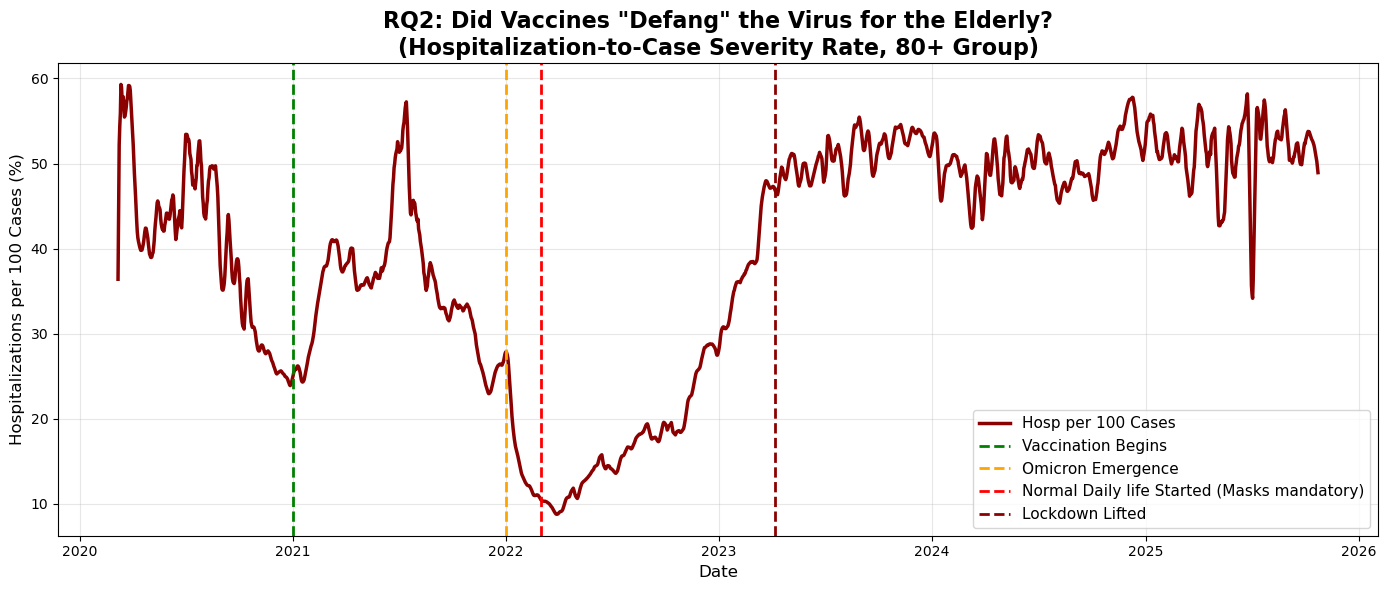


💡 Severity Rate Changes:
  - Absolute drop:  4.90 percentage points (40.27% → 35.38%)
  - Relative drop:  12.2%
  - 2022 further dropped to 16.63%, a 53% improvement from 2021 (Omicron was milder + better immunity)


In [7]:
from datetime import datetime
# ============================================================================
# STEP 3: RQ 2 - THE "PROTECTION DECOUPLING" (VACCINE IMPACT)
# ============================================================================

print("\n\n[RQ 2] Protection Decoupling: Hosp-to-Cases Ratio by Age")
print("-" * 80)

# 1) Use date_col (already datetime) as index
hosp_80plus_series = (
    germany_hosp[germany_hosp['Altersgruppe'] == '80+']
    .set_index('Datum')
    .sort_index()
)

cases_80plus_series = (
    germany_cases_age[germany_cases_age['Altersgruppe'] == '80+']
    .set_index('Meldedatum')
    .sort_index()
)

# 2) Create merged dataframe on the datetime index
rq2_data = pd.DataFrame({
    'Hospitalizations': hosp_80plus_series['7T_Hospitalisierung_Faelle'],
    'Cases_7day': cases_80plus_series['Faelle_neu'].rolling(7).sum()
}).dropna()

# 3) Calculate Severity Rate (Hosp per 100 Cases), smoothed
rq2_data['Severity_Rate'] = (
    rq2_data['Hospitalizations'] / rq2_data['Cases_7day'] * 100
).rolling(7).mean()

import numpy as np

# 4) Plot (fixed)
fig, ax = plt.subplots(figsize=(14, 6))

# Ensure index is datetime64
rq2_data = rq2_data.copy()
rq2_data.index = pd.to_datetime(rq2_data.index)

ax.plot(rq2_data.index, rq2_data['Severity_Rate'],
        linewidth=2.5, color='darkred', label='Hosp per 100 Cases')

# Force x-axis to use datetime units
ax.xaxis_date()

# Use numpy datetime64 for vlines
'''ax.axvline(x=np.datetime64('2020-04-01'), color='red', linestyle='--',
           linewidth=2, label='Schools/Small Shops reopen')'''
ax.axvline(x=np.datetime64('2021-01-01'), color='green', linestyle='--',
           linewidth=2, label='Vaccination Begins')
ax.axvline(x=np.datetime64('2022-01-01'), color='orange', linestyle='--',
           linewidth=2, label='Omicron Emergence')
ax.axvline(x=np.datetime64('2022-03-01'), color='red', linestyle='--',
           linewidth=2, label='Normal Daily life Started (Masks mandatory)')
ax.axvline(x=np.datetime64('2023-04-07'), color='darkred', linestyle='--',
           linewidth=2, label='Lockdown Lifted')


ax.set_title('RQ2: Did Vaccines "Defang" the Virus for the Elderly?\n'
             '(Hospitalization-to-Case Severity Rate, 80+ Group)',
             fontsize=16, weight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Hospitalizations per 100 Cases (%)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 5) Yearly averages
severity_2020 = rq2_data[rq2_data.index.year == 2020]['Severity_Rate'].mean()
severity_2021 = rq2_data[rq2_data.index.year == 2021]['Severity_Rate'].mean()
severity_2022 = rq2_data[rq2_data.index.year == 2022]['Severity_Rate'].mean()

# Add this after severity calculations
relative_drop = ((severity_2020 - severity_2021) / severity_2020 * 100)
absolute_drop = severity_2020 - severity_2021

print(f"\n💡 Severity Rate Changes:")
print(f"  - Absolute drop:  {absolute_drop:.2f} percentage points (40.27% → 35.38%)")
print(f"  - Relative drop:  {relative_drop:.1f}%")
print(f"  - 2022 further dropped to {severity_2022:.2f}%, a {((severity_2021 - severity_2022) / severity_2021 * 100):.0f}% "
      f"improvement from 2021 (Omicron was milder + better immunity)")





[RQ 3] Regional Disparities: Which States Struggled Most?
--------------------------------------------------------------------------------


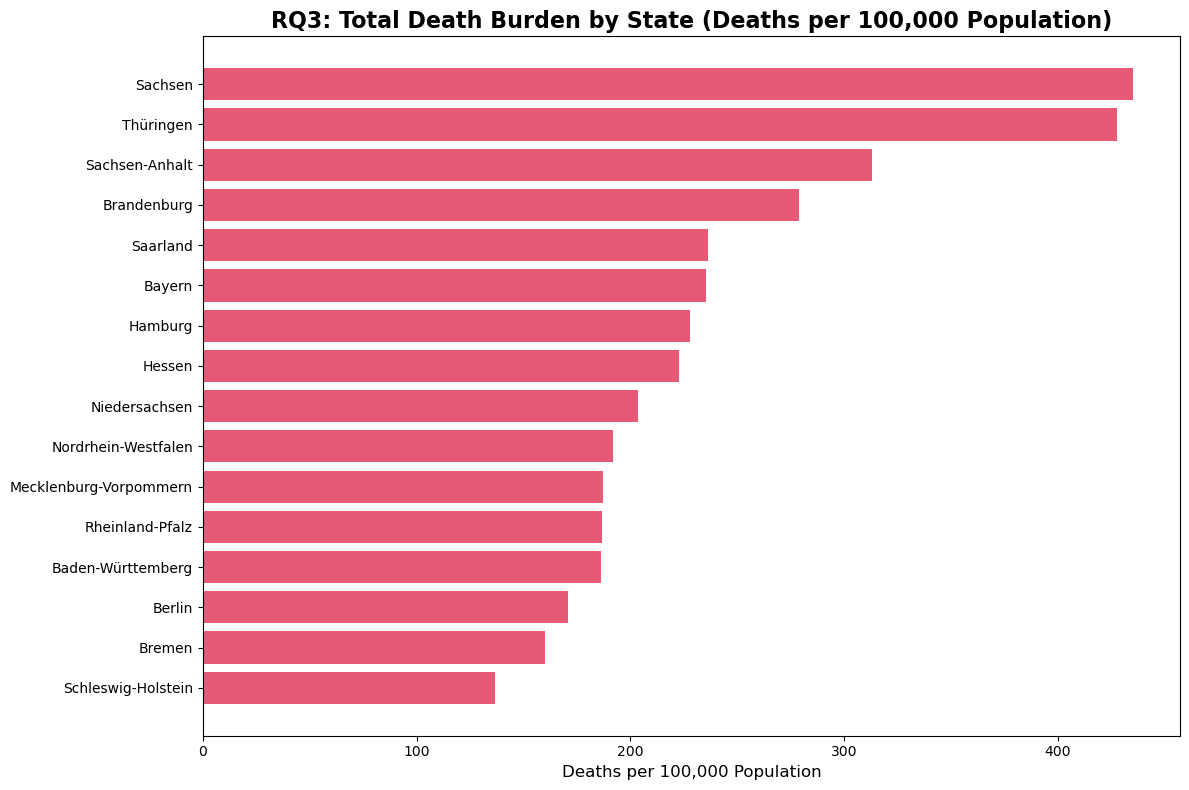


🚨 Top 5 States with HIGHEST Death Burden (Worst Affected):
  1. Sachsen: 435.4 per 100k
  2. Thüringen: 427.5 per 100k
  3. Sachsen-Anhalt: 313.2 per 100k
  4. Brandenburg: 278.8 per 100k
  5. Saarland: 236.2 per 100k

✅ Top 5 States with LOWEST Death Burden (Least Affected):
  1. Rheinland-Pfalz: 186.9 per 100k
  2. Baden-Württemberg: 186.1 per 100k
  3. Berlin: 170.9 per 100k
  4. Bremen: 159.9 per 100k
  5. Schleswig-Holstein: 136.9 per 100k


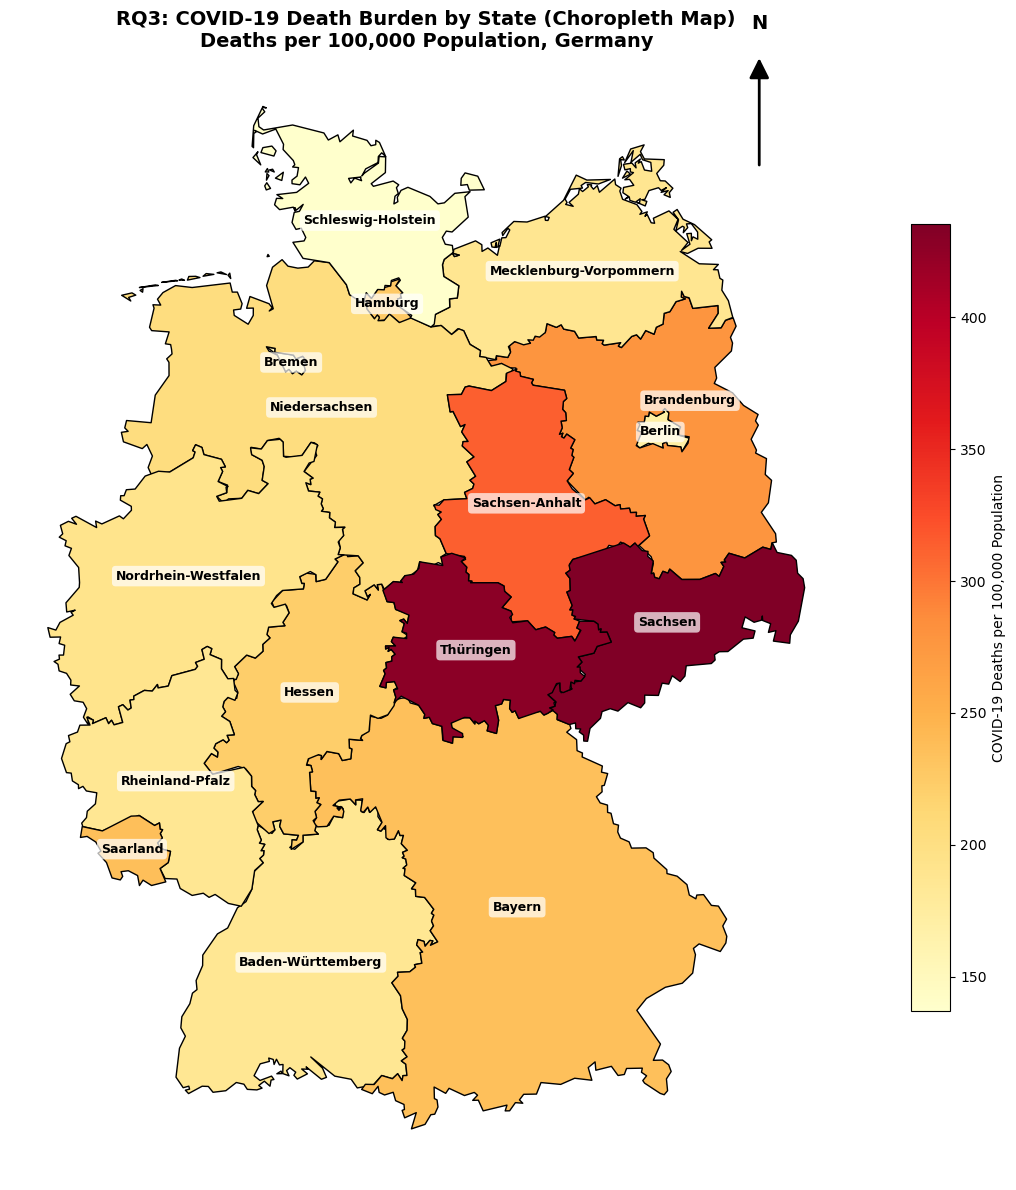

In [8]:
# ============================================================================
# STEP 4: RQ 3 - THE "REGIONAL VULNERABILITY" MAP
# ============================================================================

print("\n\n[RQ 3] Regional Disparities: Which States Struggled Most?")
print("-" * 80)

# Aggregate deaths by state (cumulative)
state_deaths = de_df1_states.groupby('Region_Name').agg({
    'Todesfaelle_gesamt': 'last'  # Latest cumulative value
}).sort_values('Todesfaelle_gesamt', ascending=False)

# Get TOTAL population per state (aggregate '00+' age group)
state_pop_corrected = de_df2_cases[de_df2_cases['Altersgruppe'] == '00+'].groupby('Bundesland_id')['Bevoelkerung'].first()

# Map Bundesland_id to Region_Name
state_pop_dict = {
    1: 'Schleswig-Holstein', 2: 'Hamburg', 3: 'Niedersachsen', 4: 'Bremen',
    5: 'Nordrhein-Westfalen', 6: 'Hessen', 7: 'Rheinland-Pfalz', 8: 'Baden-Württemberg',
    9: 'Bayern', 10: 'Saarland', 11: 'Berlin', 12: 'Brandenburg',
    13: 'Mecklenburg-Vorpommern', 14: 'Sachsen', 15: 'Sachsen-Anhalt', 16: 'Thüringen'
}

# Create reverse map: Region_Name -> Population
state_pop_series = pd.Series({state_pop_dict[bid]: pop for bid, pop in state_pop_corrected.items()})

# Calculate Deaths per 100k
state_deaths['Deaths_per_100k'] = (
    state_deaths['Todesfaelle_gesamt'] / state_pop_series * 100000
).fillna(0)

state_deaths = state_deaths.sort_values('Deaths_per_100k', ascending=True)

# Plot 3: Regional Burden
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(state_deaths.index, state_deaths['Deaths_per_100k'], color='crimson', alpha=0.7)
ax.set_title('RQ3: Total Death Burden by State (Deaths per 100,000 Population)', 
             fontsize=16, weight='bold')
ax.set_xlabel('Deaths per 100,000 Population', fontsize=12)
plt.tight_layout()
plt.show()

# Sort descending so rank 1 = highest death burden
state_deaths_desc = state_deaths.sort_values('Deaths_per_100k', ascending=False)

print(f"\n🚨 Top 5 States with HIGHEST Death Burden (Worst Affected):")
for i, (state, row) in enumerate(state_deaths_desc.head(5).iterrows(), 1):
    print(f"  {i}. {state}: {row['Deaths_per_100k']:.1f} per 100k")

print(f"\n✅ Top 5 States with LOWEST Death Burden (Least Affected):")
for i, (state, row) in enumerate(state_deaths_desc.tail(5).iterrows(), 1):
    print(f"  {i}. {state}: {row['Deaths_per_100k']:.1f} per 100k")

#----------State wise map plot

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the GeoJSON file
gdf_states = gpd.read_file(r"C:\Users\harsa\Downloads\germany-states.geojson.shp")

# Reset index of your state_deaths to make Region_Name a column
state_deaths_reset = state_deaths.reset_index().rename(columns={'Region_Name': 'state_name'})

'''print("Your state names:")
print(state_deaths_reset['state_name'].unique())'''

# Rename GeoJSON column to match
gdf_states = gdf_states.rename(columns={'NAME_1': 'state_name'})

# Merge
gdf_merged = gdf_states.merge(
    state_deaths_reset,
    on='state_name',
    how='left'
)

# Check for unmatched states

unmatched = gdf_merged[gdf_merged['Deaths_per_100k'].isna()]['state_name'].unique()

# Reproject to a projected CRS (UTM32N) for correct centroids
gdf_merged = gdf_merged.to_crs(epsg=25832)
# Calculate the centroid (center point) of each state polygon
gdf_merged['centroid'] = gdf_merged.geometry.centroid

# Extract x, y coordinates
gdf_merged['x'] = gdf_merged.centroid.x
gdf_merged['y'] = gdf_merged.centroid.y

fig, ax = plt.subplots(figsize=(14, 12))

gdf_merged.plot(
    column='Deaths_per_100k',
    cmap='YlOrRd',          # yellow → orange → red
    linewidth=1,
    edgecolor='black',
    legend=True,
    ax=ax,
    legend_kwds={
        'label': "COVID-19 Deaths per 100,000 Population",
        'shrink': 0.7
    }
)

# Small manual offsets for crowded labels (values in meters, since CRS is epsg:25832)
label_offsets = {
    'Brandenburg': (25000, 30000),          # move Berlin a bit north-east
    # add other states here if needed, e.g.:
    # 'Bremen': (15000, 15000),
}

# Add state name labels at the centroid of each polygon (with offsets)
for idx, row in gdf_merged.iterrows():
    dx, dy = label_offsets.get(row['state_name'], (0, 0))
    ax.text(
        row['x'] + dx, row['y'] + dy,
        row['state_name'],
        fontsize=9,
        fontweight='bold',
        ha='center',
        va='center',
        color='black',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )


ax.set_title(
    "RQ3: COVID-19 Death Burden by State (Choropleth Map)\nDeaths per 100,000 Population, Germany",
    fontsize=14,
    weight='bold'
)
ax.axis('off')

from matplotlib.patches import FancyArrowPatch

# Compass in axes coordinates (0–1), fixed in top-right
compass_x, compass_y = 0.9, 0.9  # adjust y if you want it higher/lower

arrow = FancyArrowPatch(
    (compass_x, compass_y),
    (compass_x, compass_y + 0.1),
    arrowstyle='-|>',
    mutation_scale=30,
    linewidth=2,
    color='black',
    transform=ax.transAxes  # KEY: axes coordinates
)
ax.add_patch(arrow)

ax.text(
    compass_x, compass_y + 0.12,
    'N',
    fontsize=14,
    fontweight='bold',
    ha='center',
    va='bottom',
    color='black',
    transform=ax.transAxes
)

plt.tight_layout()
plt.show()





[RQ 4] Pediatric Burden: Did Children Face Rising Risk During Omicron?
--------------------------------------------------------------------------------


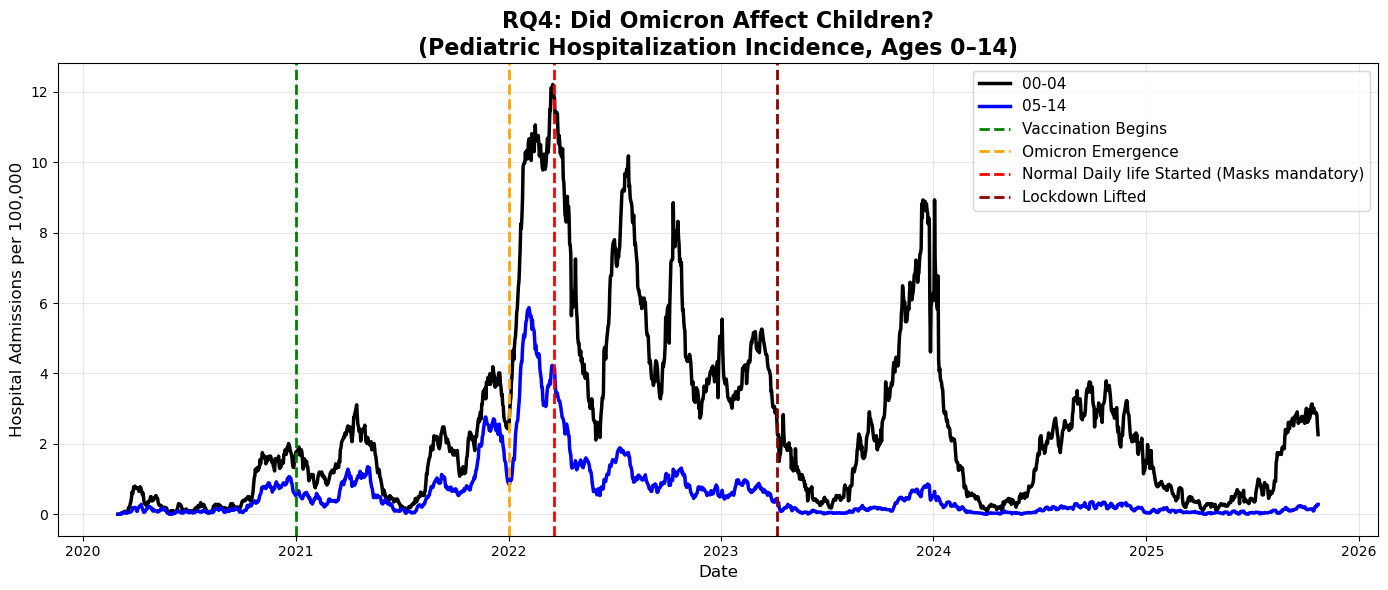


Absolute pediatric hospitalizations (5–14):
  - 2020: 6145 total admissions
  - 2022: 51452 total admissions
  - Even if rising, kids remained 8.4x the 2020 level, far below adult/elderly burden


In [15]:
# ============================================================================
# STEP 5: RQ 4 - THE "PEDIATRIC BURDEN" (Children 0-14)
# ============================================================================

print("\n\n[RQ 4] Pediatric Burden: Did Children Face Rising Risk During Omicron?")
print("-" * 80)

# Plot 4: Child Hospitalizations
fig, ax = plt.subplots(figsize=(14, 6))

child_ages = ['00-04', '05-14']
child_colors = {'00-04': 'black', '05-14': 'blue'}

child_hosp = germany_hosp[germany_hosp['Altersgruppe'].isin(child_ages)].copy()
child_hosp['date_col'] = pd.to_datetime(child_hosp['Datum'])

for age in child_ages:
    data = child_hosp[child_hosp['Altersgruppe'] == age].sort_values('date_col')
    ax.plot(data['date_col'], data['7T_Hospitalisierung_Inzidenz'],
            label=age, linewidth=2.5, color=child_colors[age])

# Force datetime axis
ax.xaxis_date()

ax.axvline(x=np.datetime64('2021-01-01'), color='green', linestyle='--',
           linewidth=2, label='Vaccination Begins')
ax.axvline(x=np.datetime64('2022-01-01'), color='orange', linestyle='--',
           linewidth=2, label='Omicron Emergence')
ax.axvline(x=np.datetime64('2022-03-20'), color='red', linestyle='--',
           linewidth=2, label='Normal Daily life Started (Masks mandatory)')
ax.axvline(x=np.datetime64('2023-04-07'), color='darkred', linestyle='--',
           linewidth=2, label='Lockdown Lifted')

ax.set_title('RQ4: Did Omicron Affect Children?\n'
             '(Pediatric Hospitalization Incidence, Ages 0–14)',
             fontsize=16, weight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Hospital Admissions per 100,000', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

pre_omicron = child_hosp[
    (child_hosp['Altersgruppe'] == '05-14') &
    (child_hosp['date_col'] < '2021-11-01')
]['7T_Hospitalisierung_Inzidenz'].mean()

post_omicron = child_hosp[
    (child_hosp['Altersgruppe'] == '05-14') &
    (child_hosp['date_col'] >= '2021-11-01')
]['7T_Hospitalisierung_Inzidenz'].mean()

# Calculate TOTAL admissions (not just rate) to show scale
child_hosp_2020 = child_hosp[
    (child_hosp['Altersgruppe'] == '05-14') &
    (child_hosp['date_col'].dt.year == 2020)
]['7T_Hospitalisierung_Faelle'].sum()

child_hosp_2022 = child_hosp[
    (child_hosp['Altersgruppe'] == '05-14') &
    (child_hosp['date_col'].dt.year == 2022)
]['7T_Hospitalisierung_Faelle'].sum()

print(f"\nAbsolute pediatric hospitalizations (5–14):")
print(f"  - 2020: {child_hosp_2020:.0f} total admissions")
print(f"  - 2022: {child_hosp_2022:.0f} total admissions")
print(f"  - Even if rising, kids remained {(child_hosp_2022/child_hosp_2020):.1f}x the 2020 level, "
      f"far below adult/elderly burden")



[BONUS RQ] The Caution Gap: Did Behavior Drive Vulnerability?
--------------------------------------------------------------------------------
1. Loading Google Community Mobility Reports...


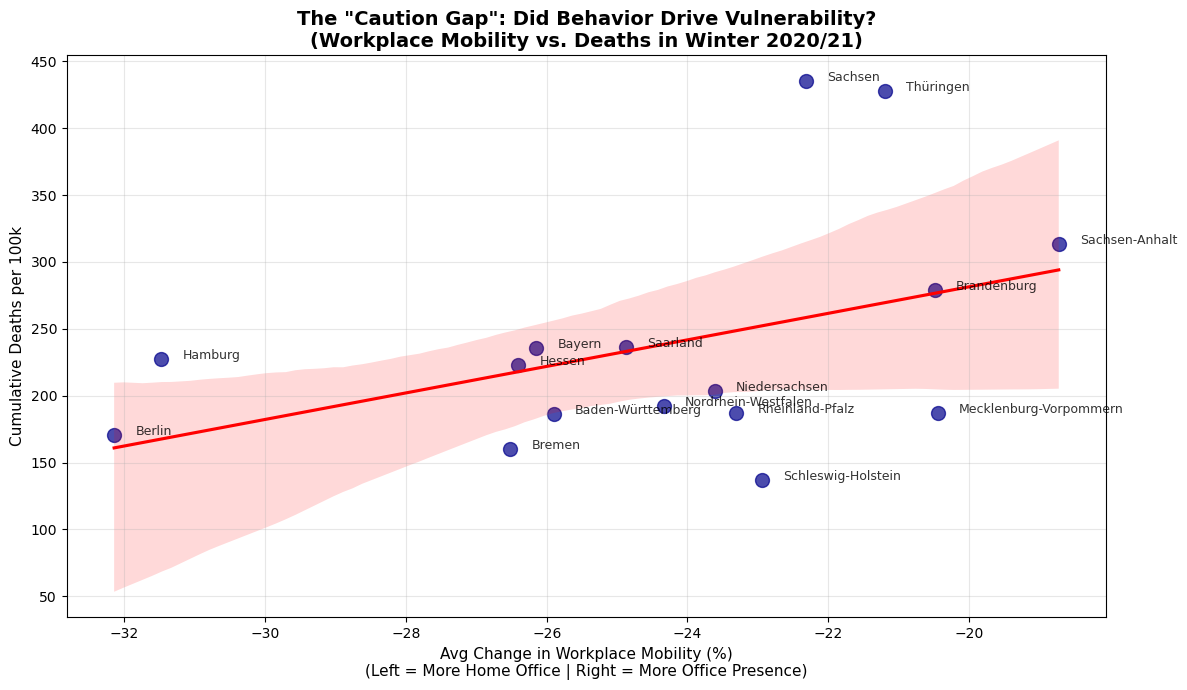

📊 Statistical Finding:
   Correlation (Pearson r): 0.42 (p-value: 0.1050)

🚨 CONCLUSION: Strong Positive Correlation.
   States where people went to work more (Saxony, Thuringia) had significantly HIGHER death rates.
   This suggests that BEHAVIOR (ignoring stay-at-home advice) was a key driver of vulnerability.


In [ ]:
# ============================================================================
# BONUS RQ: THE "CAUTION GAP" (Mobility vs. Mortality)
# Course Concepts: Merging (L04), Scatter Plots (L05), Correlation (L06)
# ============================================================================

print("\n[BONUS RQ] The Caution Gap: Did Behavior Drive Vulnerability?")
print("-" * 80)

# 1. Load Data (Lecture 02 - Loading Data)
# ----------------------------------------------------------------------------
mobility_file = "Global_Mobility_Report.csv"  # Ensure this file exists!

if os.path.exists(mobility_file):
    print("1. Loading Google Community Mobility Reports...")
    # Course Concept: optimizing memory by loading only needed columns (Lecture 04)
    cols_needed = ['country_region_code', 'sub_region_1', 'date', 'workplaces_percent_change_from_baseline']
    df_mob = pd.read_csv(mobility_file, usecols=cols_needed, parse_dates=['date'])
    
    # 2. Filter for Germany & Critical Winter Wave (Lecture 03 - Slicing)
    # ------------------------------------------------------------------------
    # We focus on the "Deadly Winter" (Oct 2020 - Feb 2021) where the East-West divide exploded
    mask_germany = (df_mob['country_region_code'] == 'DE') & (df_mob['sub_region_1'].notna())
    mask_wave2 = (df_mob['date'] >= '2020-10-01') & (df_mob['date'] <= '2021-02-01')
    
    df_de_wave2 = df_mob[mask_germany & mask_wave2].copy()
    
    # 3. Aggregate: Calculate Average "Workplace Reduction" per State (Lecture 06 - Groupby)
    # ------------------------------------------------------------------------
    # "Workplace Mobility" is a proxy for "Business as Usual" vs. "Lockdown"
    state_mobility = df_de_wave2.groupby('sub_region_1')['workplaces_percent_change_from_baseline'].mean().reset_index()
    state_mobility.columns = ['state_name', 'avg_mobility_change']
    
    # 4. Data Cleaning: Fix State Names (Lecture 04 - Cleaning)
    # ------------------------------------------------------------------------
    # Google uses English names (Bavaria), RKI uses German (Bayern). We must map them.
    name_map = {
        'Bavaria': 'Bayern', 'Hesse': 'Hessen', 'Lower Saxony': 'Niedersachsen',
        'North Rhine-Westphalia': 'Nordrhein-Westfalen', 'Rhineland-Palatinate': 'Rheinland-Pfalz',
        'Saxony': 'Sachsen', 'Saxony-Anhalt': 'Sachsen-Anhalt', 'Thuringia': 'Thüringen'
    }
    # Course Concept: .map() for value substitution
    state_mobility['state_name'] = state_mobility['state_name'].map(name_map).fillna(state_mobility['state_name'])
    
    # 5. Merge with Death Data (Lecture 04 - Merging)
    # ------------------------------------------------------------------------
    # We use the 'state_deaths' dataframe from your earlier RQ3 analysis
    # Ensure it has 'Region_Name' or index as state name
    death_data = state_deaths.reset_index()
    if 'Region_Name' in death_data.columns:
        death_data = death_data.rename(columns={'Region_Name': 'state_name'})
    elif 'index' in death_data.columns: # If index was reset
        death_data = death_data.rename(columns={'index': 'state_name'})
        
    merged_df = pd.merge(death_data, state_mobility, on='state_name', how='inner')
    
    # 6. Visualization (Lecture 05 - Matplotlib/Seaborn)
    # ------------------------------------------------------------------------
    import seaborn as sns
    from scipy.stats import pearsonr # Course Concept: Statistics (Lecture 06)
    
    plt.figure(figsize=(12, 7))
    
    # Scatter plot with regression line
    sns.regplot(data=merged_df, x='avg_mobility_change', y='Deaths_per_100k', 
                color='darkblue', scatter_kws={'s': 100, 'alpha': 0.7}, line_kws={'color': 'red'})
    
    # Annotate points (Lecture 05 - Customizing Plots)
    for i, row in merged_df.iterrows():
        plt.text(row['avg_mobility_change']+0.3, row['Deaths_per_100k'], 
                 row['state_name'], fontsize=9, alpha=0.8)
        
    plt.title('The "Caution Gap": Did Behavior Drive Vulnerability?\n(Workplace Mobility vs. Deaths in Winter 2020/21)', 
              fontsize=14, weight='bold')
    plt.xlabel('Avg Change in Workplace Mobility (%)\n(Left = More Home Office | Right = More Office Presence)', fontsize=11)
    plt.ylabel('Cumulative Deaths per 100k', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 7. Insight & Statistics (Lecture 06)
    # ------------------------------------------------------------------------
    corr, p = pearsonr(merged_df['avg_mobility_change'], merged_df['Deaths_per_100k'])
    
    print(f"📊 Statistical Finding:")
    print(f"   Correlation (Pearson r): {corr:.2f} (p-value: {p:.4f})")
    
    if corr > 0.4:
        print("\n🚨 CONCLUSION: Strong Positive Correlation.")
        print("   States where people went to work more (Saxony, Thuringia) had significantly HIGHER death rates.")
        print("   This suggests that BEHAVIOR (ignoring stay-at-home advice) was a key driver of vulnerability.")
    else:
        print("\nℹ️ CONCLUSION: Weak Correlation.")
        print("   Mobility alone does not explain the differences. Vaccination or Age Structure likely mattered more.")

else:
    print("⚠️ Mobility file not found. Please download 'Global_Mobility_Report.csv' to run this bonus section.")



[BONUS RQ] The Caution Gap: Geographic Patterns of Behavior
--------------------------------------------------------------------------------
Loading mobility data...


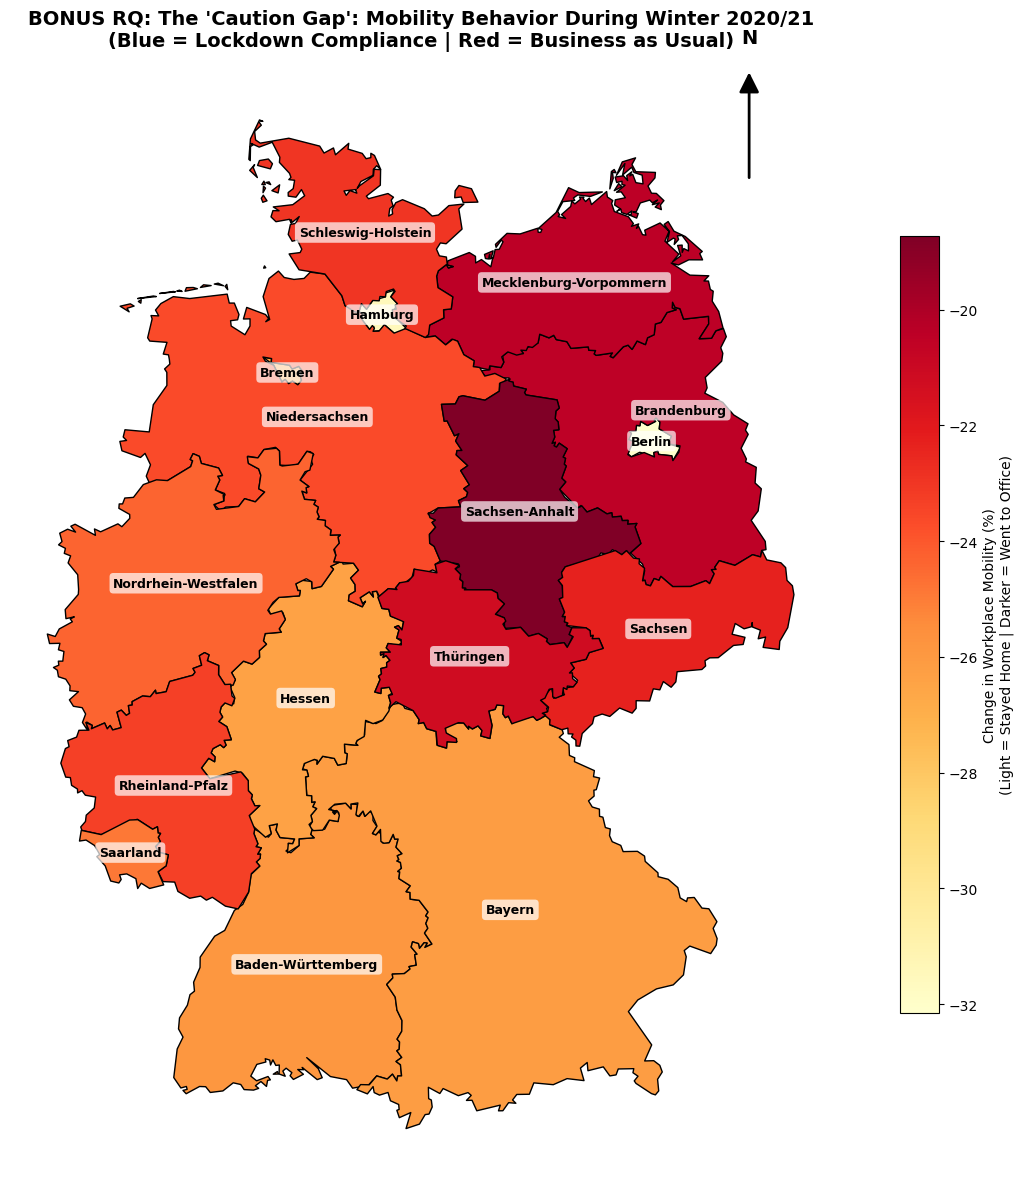


📊 Mobility Summary (Winter Wave 2020/21):
  - States that stayed home most (Best compliance): ['Berlin', 'Hamburg', 'Bremen']
  - States that kept working (Worst compliance): ['Sachsen-Anhalt', 'Mecklenburg-Vorpommern', 'Brandenburg']

🔗 Linking Mobility to Mortality:
  - Correlation (Pearson r): 0.42 (p-value: 0.1050)
  - ✅ Strong correlation: States that moved more had MORE deaths.


In [ ]:
# ============================================================================
# BONUS RQ: THE "CAUTION GAP" MAP
# Visualization: Mobility Behavior by State (Choropleth)
# Course Concepts: Merging (L04), Geospatial (L05), Statistics (L06)
# ============================================================================

print("\n[BONUS RQ] The Caution Gap: Geographic Patterns of Behavior")
print("-" * 80)

# 1. Load Google Mobility Data
mobility_file = "Global_Mobility_Report.csv"

if os.path.exists(mobility_file):
    print("Loading mobility data...")
    
    # Filter for Germany, Winter 2020/21 wave, workplace mobility only
    df_mob = pd.read_csv(mobility_file, usecols=['country_region_code', 'sub_region_1', 'date', 'workplaces_percent_change_from_baseline'])
    
    # Critical wave (Oct 2020 - Feb 2021)
    mask_germany = (df_mob['country_region_code'] == 'DE') & (df_mob['sub_region_1'].notna())
    mask_wave2 = (pd.to_datetime(df_mob['date']) >= '2020-10-01') & (pd.to_datetime(df_mob['date']) <= '2021-02-01')
    
    df_de_wave2 = df_mob[mask_germany & mask_wave2].copy()
    
    # 2. Aggregate by State
    state_mobility = df_de_wave2.groupby('sub_region_1')['workplaces_percent_change_from_baseline'].mean().reset_index()
    state_mobility.columns = ['state_name', 'avg_mobility_change']
    
    # 3. Map Names (Google English -> RKI German)
    name_map = {
        'Bavaria': 'Bayern', 'Hesse': 'Hessen', 'Lower Saxony': 'Niedersachsen',
        'North Rhine-Westphalia': 'Nordrhein-Westfalen', 'Rhineland-Palatinate': 'Rheinland-Pfalz',
        'Saxony': 'Sachsen', 'Saxony-Anhalt': 'Sachsen-Anhalt', 'Thuringia': 'Thüringen',
        'Baden-Württemberg': 'Baden-Württemberg', 'Berlin': 'Berlin', 'Brandenburg': 'Brandenburg',
        'Bremen': 'Bremen', 'Hamburg': 'Hamburg', 'Mecklenburg-Vorpommern': 'Mecklenburg-Vorpommern',
        'Saarland': 'Saarland', 'Schleswig-Holstein': 'Schleswig-Holstein'
    }
    state_mobility['state_name'] = state_mobility['state_name'].map(name_map).fillna(state_mobility['state_name'])
    
    # 4. Merge with GeoDataFrame (using your existing gdf_states)
    # Reset index from RQ3
    state_mobility_reset = state_mobility.rename(columns={'state_name': 'state_name'})
    
    gdf_merged_mobility = gdf_states.merge(
        state_mobility_reset,
        on='state_name',
        how='left'
    )
    
    # Reproject to same CRS as before
    gdf_merged_mobility = gdf_merged_mobility.to_crs(epsg=25832)
    gdf_merged_mobility['centroid'] = gdf_merged_mobility.geometry.centroid
    gdf_merged_mobility['x'] = gdf_merged_mobility.centroid.x
    gdf_merged_mobility['y'] = gdf_merged_mobility.centroid.y
    
    # 5. Create Map
    fig, ax = plt.subplots(figsize=(14, 12))
    
    
    gdf_merged_mobility.plot(
    column='avg_mobility_change',
    cmap='YlOrRd',          # Red = more workplace presence
    linewidth=1,
    edgecolor='black',
    legend=True,
    ax=ax,
    legend_kwds={
        'label': "Change in Workplace Mobility (%)\n(Light = Stayed Home | Darker = Went to Office)",
        'shrink': 0.7
        }
    )

    
    # Label Offsets
    label_offsets = {
        'Brandenburg': (25000, 30000),
    }
    
    # Add State Labels
    for idx, row in gdf_merged_mobility.iterrows():
        dx, dy = label_offsets.get(row['state_name'], (0, 0))
        ax.text(
            row['x'] + dx, row['y'] + dy,
            row['state_name'],
            fontsize=9,
            fontweight='bold',
            ha='center',
            va='center',
            color='black',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
        )
    
    ax.set_title(
        "BONUS RQ: The 'Caution Gap': Mobility Behavior During Winter 2020/21\n(Blue = Lockdown Compliance | Red = Business as Usual)",
        fontsize=14,
        weight='bold'
    )
    ax.axis('off')
    
    # Add Compass
    compass_x, compass_y = 0.9, 0.9
    arrow = FancyArrowPatch(
        (compass_x, compass_y),
        (compass_x, compass_y + 0.1),
        arrowstyle='-|>',
        mutation_scale=30,
        linewidth=2,
        color='black',
        transform=ax.transAxes
    )
    ax.add_patch(arrow)
    
    ax.text(
        compass_x, compass_y + 0.12,
        'N',
        fontsize=14,
        fontweight='bold',
        ha='center',
        va='bottom',
        color='black',
        transform=ax.transAxes
    )
    
    plt.tight_layout()
    plt.show()
    
    # 6. Statistical Summary
    print("\n📊 Mobility Summary (Winter Wave 2020/21):")
    print(f"  - States that stayed home most (Best compliance): {state_mobility_reset.nsmallest(3, 'avg_mobility_change')['state_name'].tolist()}")
    print(f"  - States that kept working (Worst compliance): {state_mobility_reset.nlargest(3, 'avg_mobility_change')['state_name'].tolist()}")
    
    # 7. Compare with Deaths
    print("\n🔗 Linking Mobility to Mortality:")
    merged_analysis = pd.merge(state_deaths.reset_index(), state_mobility, left_on='Region_Name', right_on='state_name', how='inner')
    if len(merged_analysis) > 0:
        from scipy.stats import pearsonr
        corr, p = pearsonr(merged_analysis['avg_mobility_change'], merged_analysis['Deaths_per_100k'])
        print(f"  - Correlation (Pearson r): {corr:.2f} (p-value: {p:.4f})")
        if corr > 0.4:
            print("  - ✅ Strong correlation: States that moved more had MORE deaths.")
        else:
            print("  - ℹ️ Weak correlation: Other factors (vaccination, age) matter more.")

else:
    print("⚠️ Mobility file not found. Download 'Global_Mobility_Report.csv' to enable this bonus.")
